In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import shap

c:\Users\VR685BL\OneDrive - EY\11_Others\MB_ALM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_excel(r'C:\Users\VR685BL\OneDrive - EY\11_Others\MB_ALM\MBALM_MHHV_Research PPL\Model_CASA_Regression_v3.xlsx', sheet_name='Input', header=2)
data

,Month,Year,REPORTING_DATE,EOP_BALANCE,Interest_rate,Market_rate,Crude_oil_index,Stock_indices1,Stock_indices2,Real_GDP,Real_non-oil_GDP
0,7,2018,2018-07-31,3.022399e+10,0.005372,0.026193,73.790,4859.45,2955.95,0.013373,0.008170
1,8,2018,2018-08-31,3.050821e+10,0.005885,0.025341,76.010,4986.88,3637.55,0.015261,0.007461
2,9,2018,2018-09-30,2.843667e+10,0.004835,0.024455,81.830,4935.37,2834.95,0.017089,0.006774
3,10,2018,2018-10-31,2.887651e+10,0.005495,0.027637,74.170,4901.87,2784.60,0.021978,0.000830
4,11,2018,2018-11-30,2.777955e+10,0.005136,0.026675,57.750,4770.08,3420.17,0.026710,0.004924
...,...,...,...,...,...,...,...,...,...,...,...
56,3,2023,2023-03-31,6.702705e+10,0.015473,0.049100,79.045,9430.25,3406.72,0.038000,0.045000
57,4,2023,2023-04-30,6.353635e+10,0.016092,0.049909,82.145,9789.17,3544.79,0.038000,0.054231
58,5,2023,2023-05-31,6.220850e+10,0.016205,0.052233,72.845,9406.57,3576.63,0.038000,0.063769
59,6,2023,2023-06-30,6.605451e+10,0.018617,0.051670,74.970,9550.40,3791.99,0.038000,0.073000


In [3]:
# Split the data into features (X) and target (y)
X = data.drop(['Month', 'Year', 'REPORTING_DATE', 'EOP_BALANCE'], axis=1)
y = data['EOP_BALANCE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. Vanilla model

In [4]:
# define XGBoost regressor
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',        # fast on large data
    n_jobs=-1
)
xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [5]:
y_pred = xgb.predict(X_test)
print("Test  MAPE:", mape(y_test, y_pred) * 100)

Test  MAPE: 3.916157255631532


### 2. Tuned model

In [6]:
# search‐space for XGBoost hyperparameters
search_spaces = {
    'n_estimators': Integer(100, 5000),
    'max_depth': Integer(3, 15),
    'learning_rate': Real(1e-3, 0.3, prior='log-uniform'),
    'subsample': Real(0.0, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.0, 1.0, prior='uniform'),
    'gamma': Real(0, 5, prior='uniform'),
    'reg_alpha': Real(1e-8, 20, prior='log-uniform'),
    'reg_lambda': Real(1e-8, 20, prior='log-uniform')
}

# BayesSearchCV to minimize MAPE
bayes_cv = BayesSearchCV(
    estimator=xgb, search_spaces=search_spaces, scoring='neg_mean_absolute_percentage_error',
    n_iter=32, cv=5, n_jobs=-1, random_state=42, verbose=0
)

bayes_cv.fit(X_train, y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,search_spaces,"{'colsample_bytree': Real(low=0.0,...m='normalize'), 'gamma': Real(low=0, h...m='normalize'), 'learning_rate': Real(low=0.00...m='normalize'), 'max_depth': Integer(low=3...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,32
,scoring,'neg_mean_absolute_percentage_error'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,5


In [7]:
# Create a variable for the best model
best_xgb = bayes_cv.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  bayes_cv.best_params_)

Best hyperparameters: OrderedDict([('colsample_bytree', 1.0), ('gamma', 2.2358222546860387), ('learning_rate', 0.04026599538512625), ('max_depth', 14), ('n_estimators', 100), ('reg_alpha', 20.0), ('reg_lambda', 1e-08), ('subsample', 0.7905834219479432)])


In [8]:
# Generate predictions with the best model
y_pred = bayes_cv.predict(X_test)

print("Test  MAPE:", mape(y_test, y_pred) * 100)
# print("Test   R²:", bayes_cv.score(X_test, y_test))

Test  MAPE: 4.0583391666713275


<Axes: >

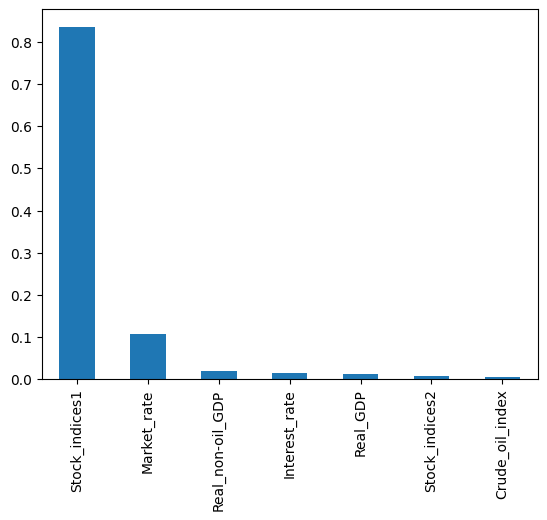

In [9]:
# Create a series contain feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

In [10]:
# Use SHAP to explain the model predictions
explainer = shap.TreeExplainer(best_xgb)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

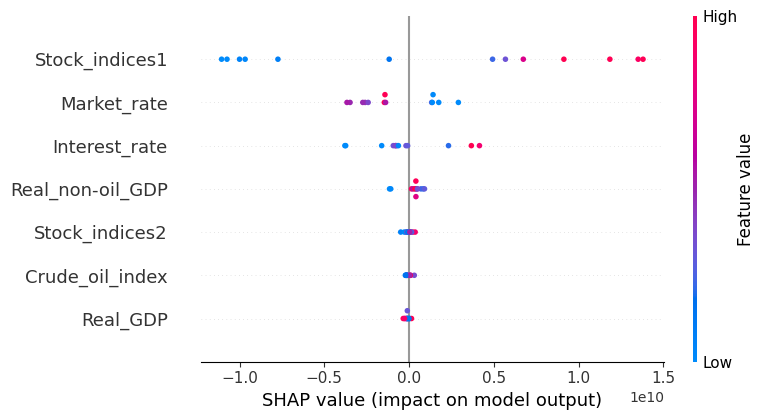

In [11]:
# Plot the SHAP values
shap.summary_plot(shap_values, X_test)